In [1]:
import reservoirpy as rpy
from reservoirpy.datasets import lorenz
from reservoirpy.datasets import rossler

import numpy as np
from matplotlib import pyplot as plt

rpy.verbosity(False)

rpy.set_seed(42)

name_idx = 0

In [3]:
def add_noise(time_series, noise_type="random", noise_level=0.5):
    """
    对输入的时间序列添加噪声。
    
    参数:
        time_series (numpy.ndarray): 输入的时间序列。
        noise_type (str): 噪声类型，可选值为 "random"（随机噪声）, "sin"（正弦噪声）, 或 "gaussian"（正态分布噪声）。
        noise_level (float): 噪声强度，决定噪声幅度。
    
    返回:
        numpy.ndarray: 添加噪声后的时间序列。
    """
    if noise_type == "random":
        noise = np.random.uniform(-noise_level, noise_level, len(time_series))
    elif noise_type == "sin":
        noise = noise_level * np.sin(30 * np.pi * np.arange(len(time_series)) / len(time_series))
    elif noise_type == "gaussian":
        noise = np.random.normal(0, noise_level, len(time_series))
    else:
        raise ValueError("Unsupported noise_type. Choose from 'random', 'sin', or 'gaussian'.")
    
    return time_series + np.stack((noise,noise,noise)).T

In [4]:
def show(t1, t2, figsize1=(18, 6)):
    plt.figure(figsize=figsize1)

    plt.subplot(3, 1, 1)
    plt.plot(t2[:,0], label='prediction')
    plt.plot(t1[:,0], label='target', linestyle='--', color='#ff7f0e')
    
    plt.title('Lorenz X-component')

    plt.subplot(3, 1, 2)
    plt.plot(t2[:,1], label='prediction')
    plt.plot(t1[:,1], label='target', linestyle='--', color='#ff7f0e')
    
    plt.title('Lorenz Y-component')

    plt.subplot(3, 1, 3)
    plt.plot(t2[:,2], label='prediction')
    plt.plot(t1[:,2], label='target', linestyle='--', color='#ff7f0e')
    
    plt.title('Lorenz Z-component')
    
    fig = plt.figure(figsize=(12,5), dpi=150)
    
    rmse = np.sqrt(np.mean((t1 - t2)**2))
    fig.suptitle("Lorenz Attractor-RMSE: {:.8f}".format(rmse))
    
    ax = fig.add_subplot(121, projection='3d')
    ax.plot(t2[:,0], t2[:,1], t2[:,2])
    ax.set_title("Lorenz")

    ax = fig.add_subplot(122, projection='3d')
    ax.plot(t1[:,0], t1[:,1], t1[:,2], color='#ff7f0e')
    ax.set_title("Processed Lorenz")
    
    plt.show()

In [5]:
data = lorenz(10000, h=0.001)[2000:,:]

norm01 = lambda x: (x - np.min(x, axis=0)) / (np.max(x, axis=0) - np.min(x, axis=0)) * 2 - 1

data = norm01(data)

In [6]:
input_data = add_noise(data[:1000,:], 'gaussian', noise_level=0.8)
target_input = data[:1000,:]

test_data = add_noise(data[1000:2000,:], "gaussian", noise_level=0.8)
target_test = data[1000:2000,:]

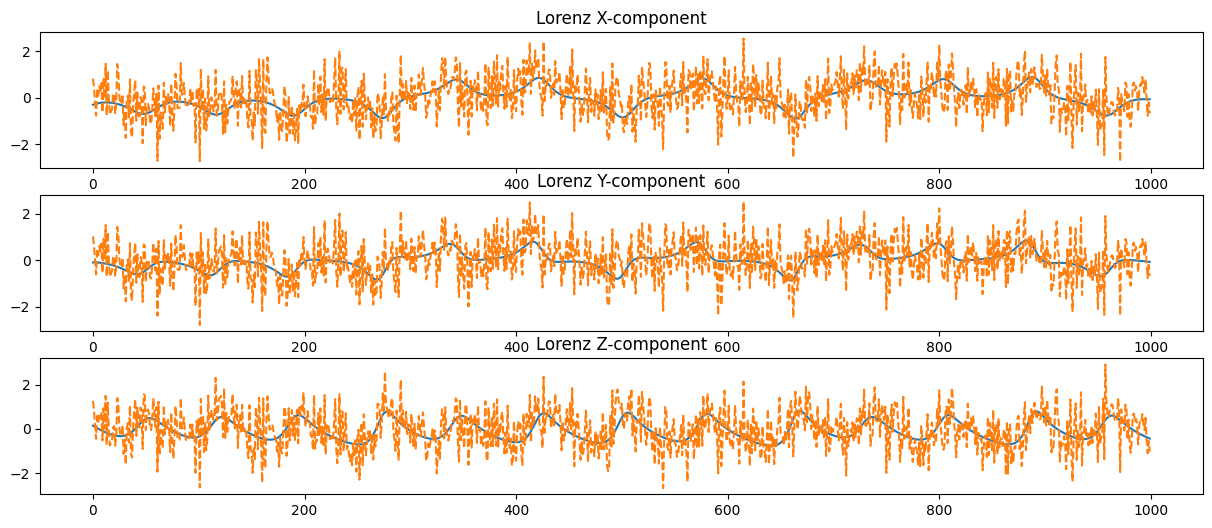

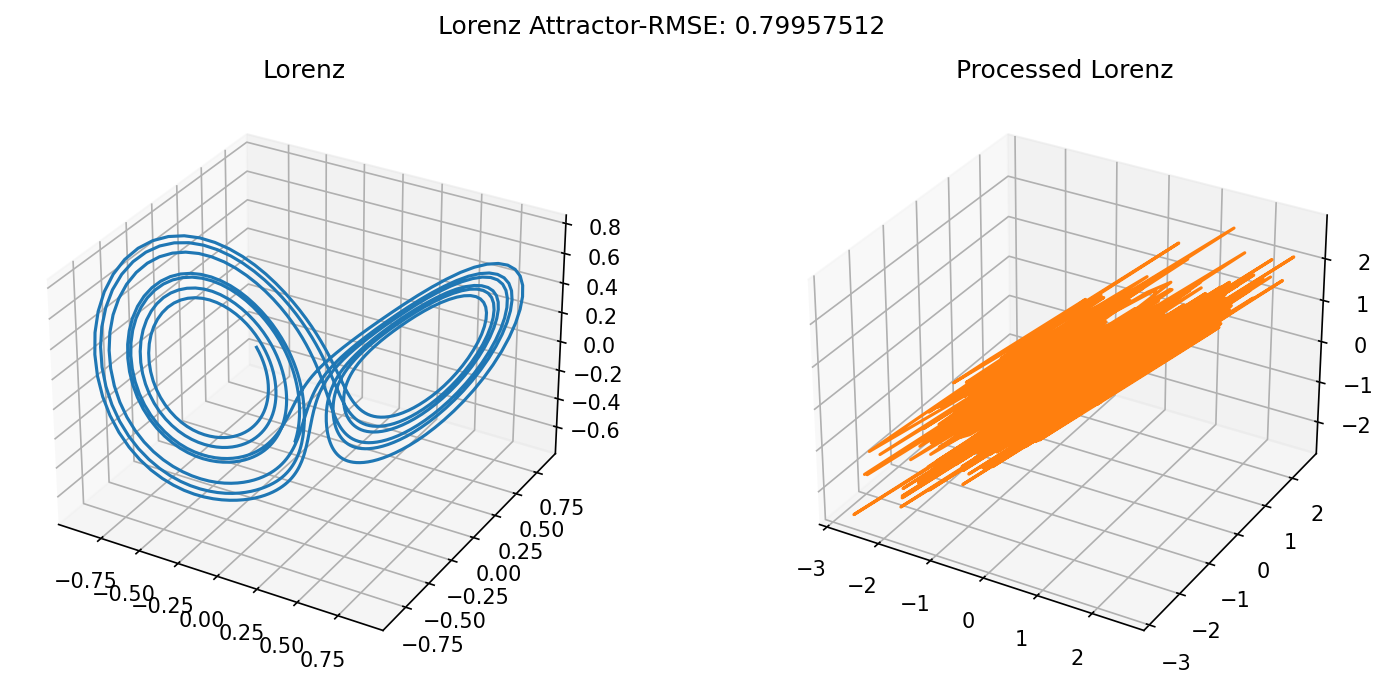

In [7]:
show(test_data, target_test, figsize1=(15,6))

In [8]:
name_idx += 1

inp = rpy.nodes.Input(input_dim=3)
oup1 = rpy.nodes.Output(output_dim=3, name='output1'+str(name_idx))
oup2 = rpy.nodes.Output(output_dim=3, name='output2'+str(name_idx))
oup3 = rpy.nodes.Output(output_dim=3, name='output3'+str(name_idx))

rdo1 = rpy.nodes.Ridge(output_dim=3, ridge=1e-7, name='reo1'+str(name_idx))
rdo2 = rpy.nodes.Ridge(output_dim=3, ridge=1e-7, name='reo2'+str(name_idx))
rdo3 = rpy.nodes.Ridge(output_dim=3, ridge=1e-7, name='reo3'+str(name_idx))

res1 = rpy.nodes.Reservoir(1000, lr=0.8, sr=0.9, noise_fb=0, equation='external', activation='sig')
res2 = rpy.nodes.Reservoir(1000, lr=0.2, sr=0.9, noise_fb=0, equation='external', activation='tanh')
res3 = rpy.nodes.Reservoir(1000, lr=0.2, sr=0.9, noise_fb=0, equation='external', activation='tanh')

esn = inp >> res1 >> rdo1 >> res2 >> rdo2 >> res3 >> rdo3 >> oup3 & \
      rdo1 >> oup1 & \
      rdo2 >> oup2

In [10]:
esn = esn.fit(input_data, {'reo1'+str(name_idx):target_input,
                           'reo2'+str(name_idx):target_input,
                           'reo3'+str(name_idx):target_input})

In [ ]:
pred = esn.run(test_data)

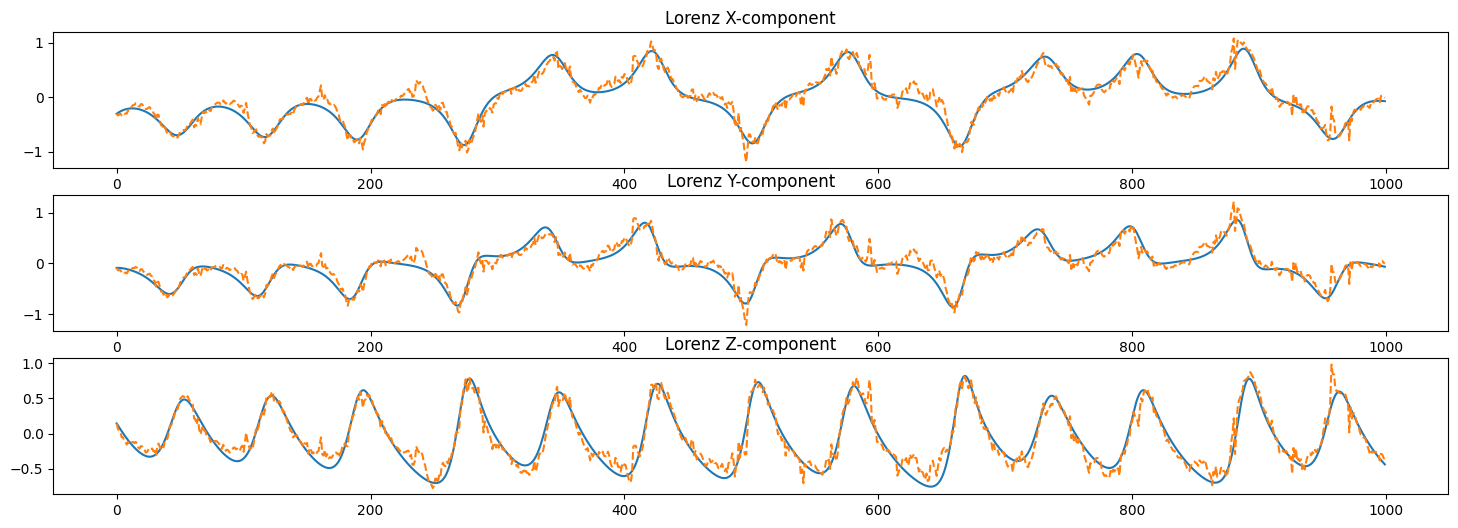

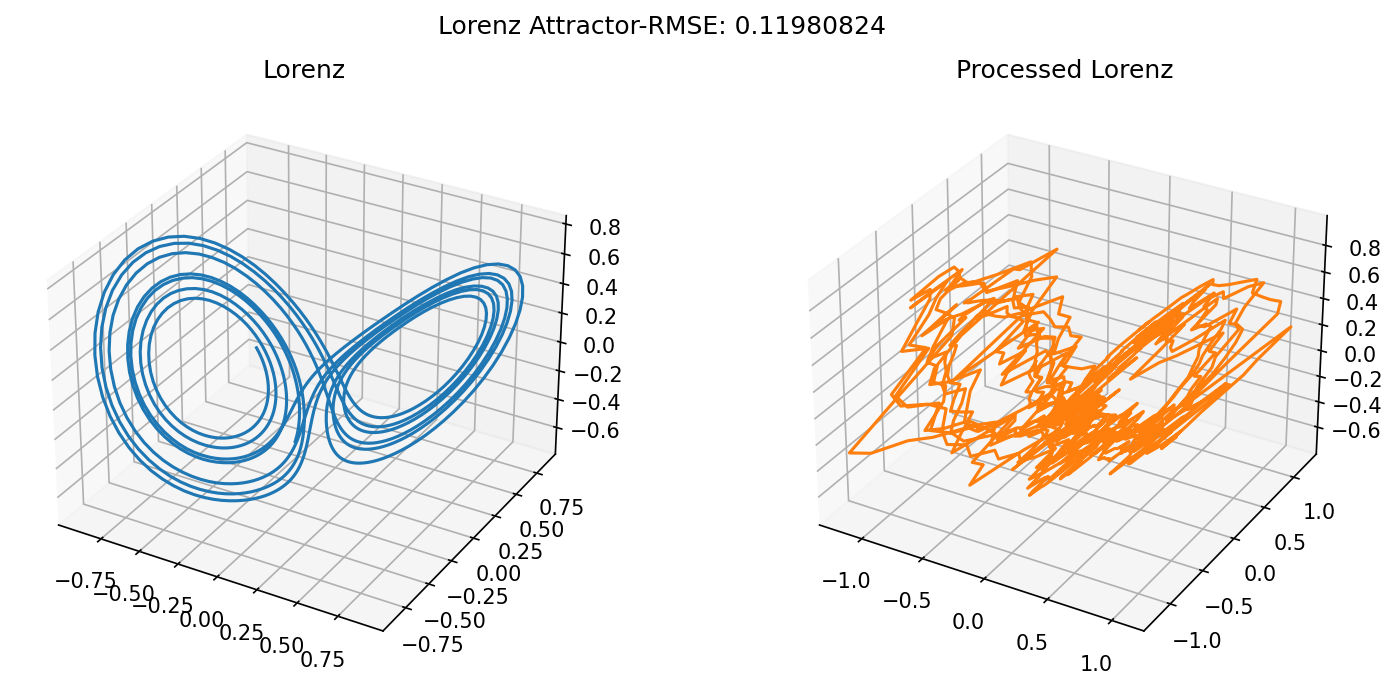

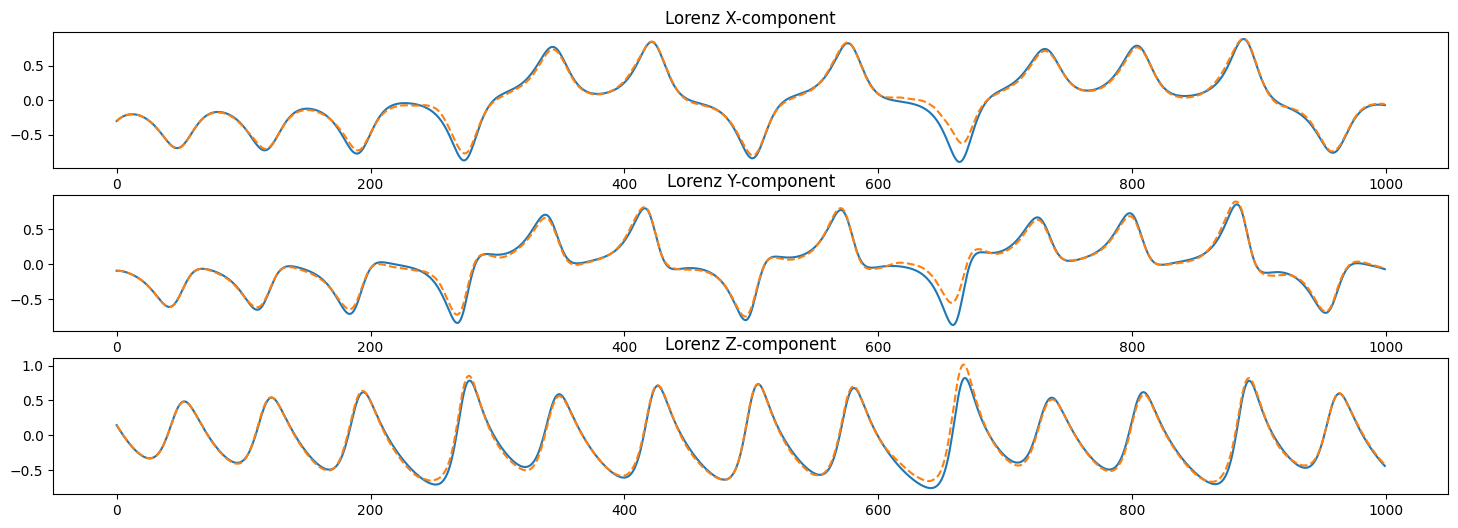

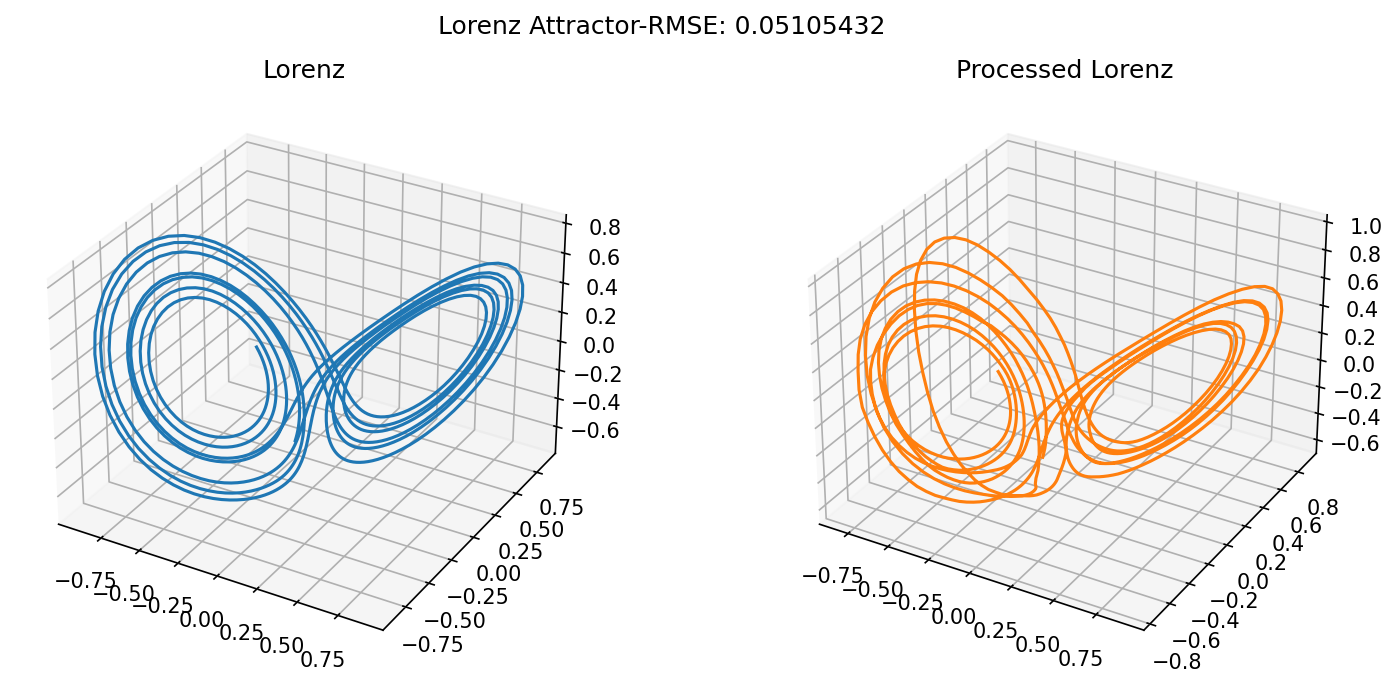

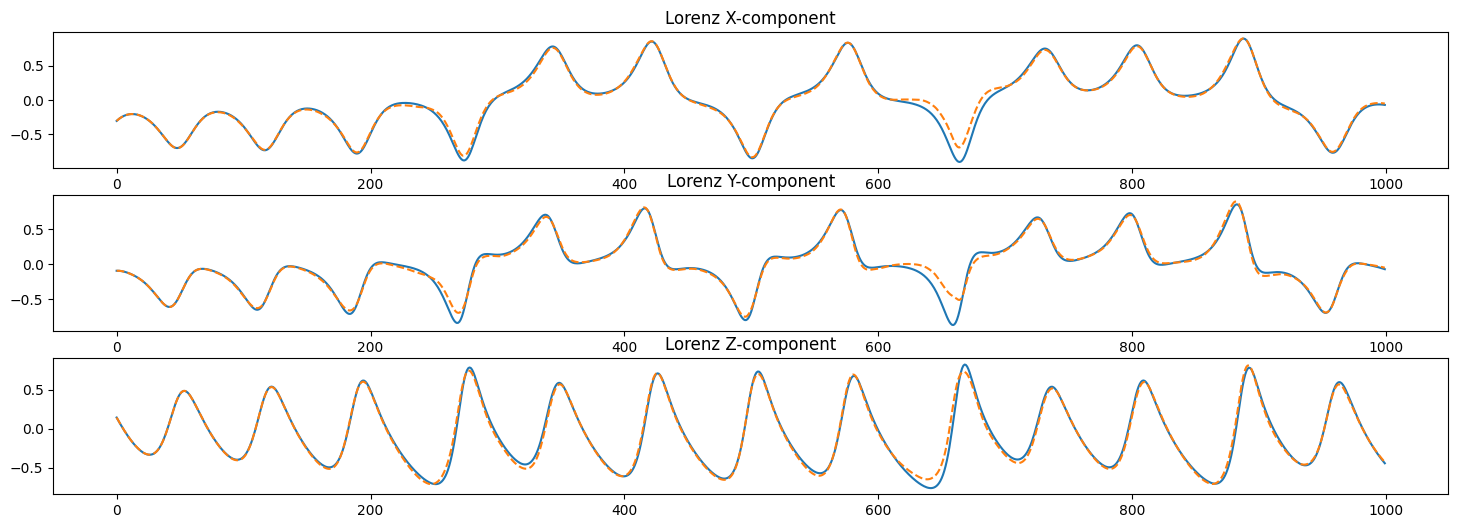

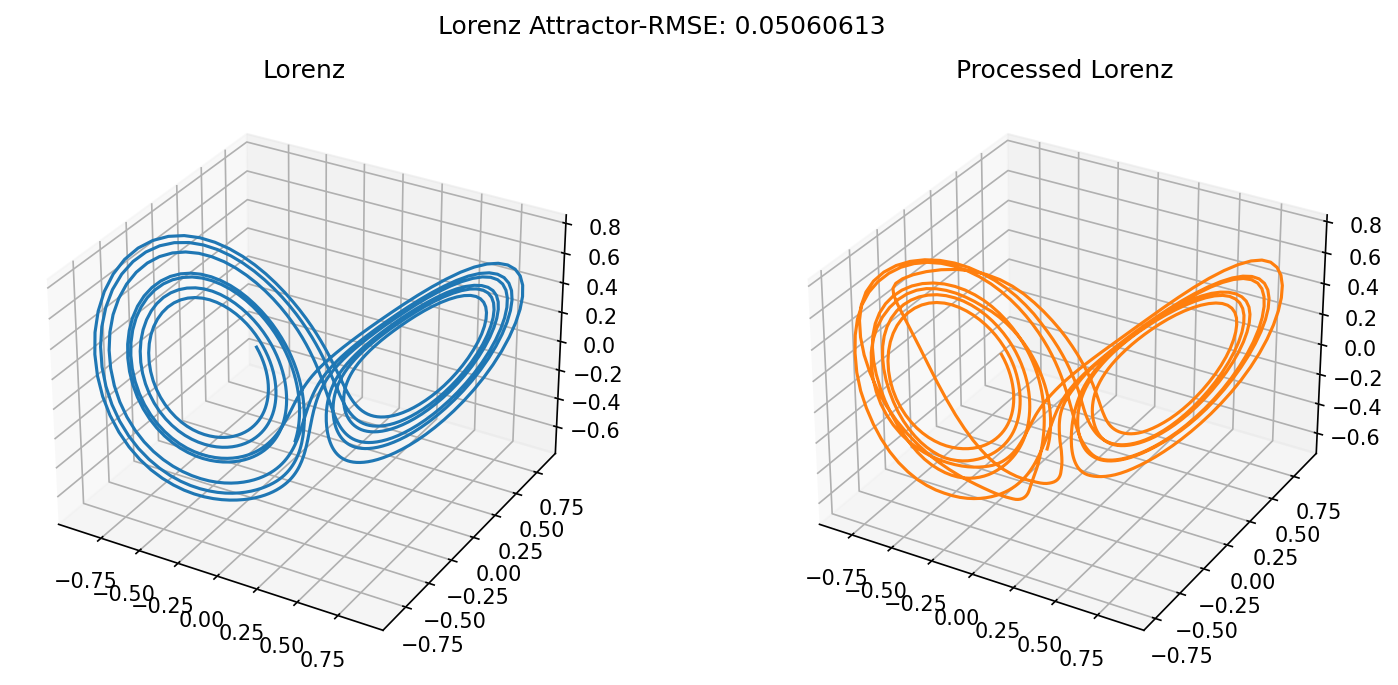

In [12]:
show(pred['output1'+str(name_idx)], target_test)
show(pred['output2'+str(name_idx)], target_test)
show(pred['output3'+str(name_idx)], target_test)

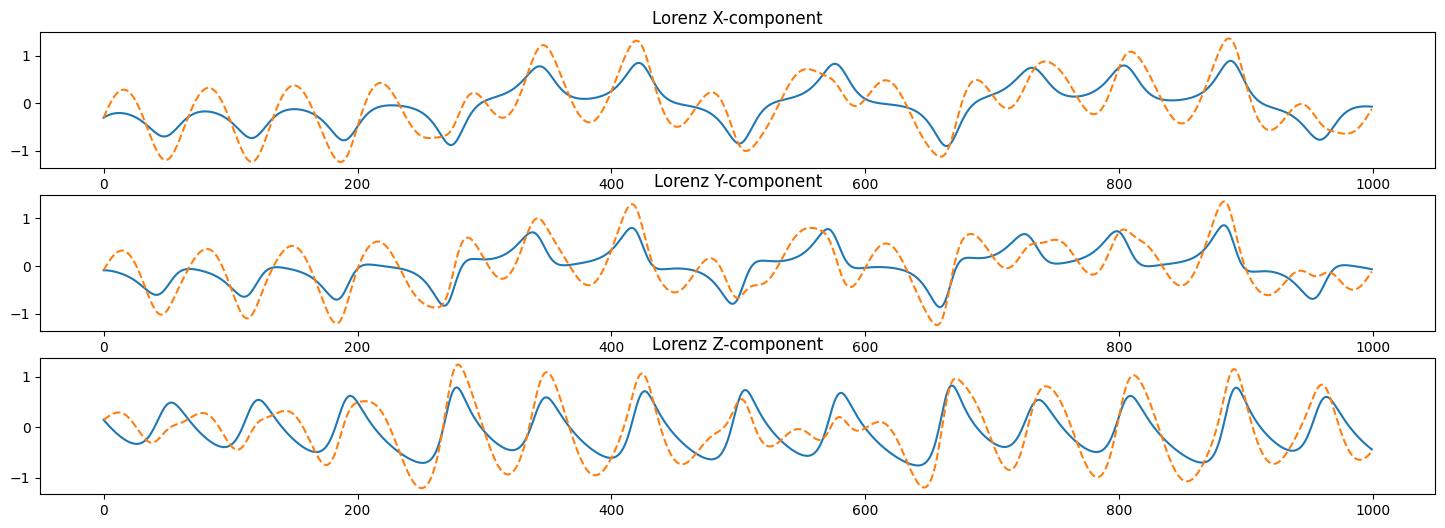

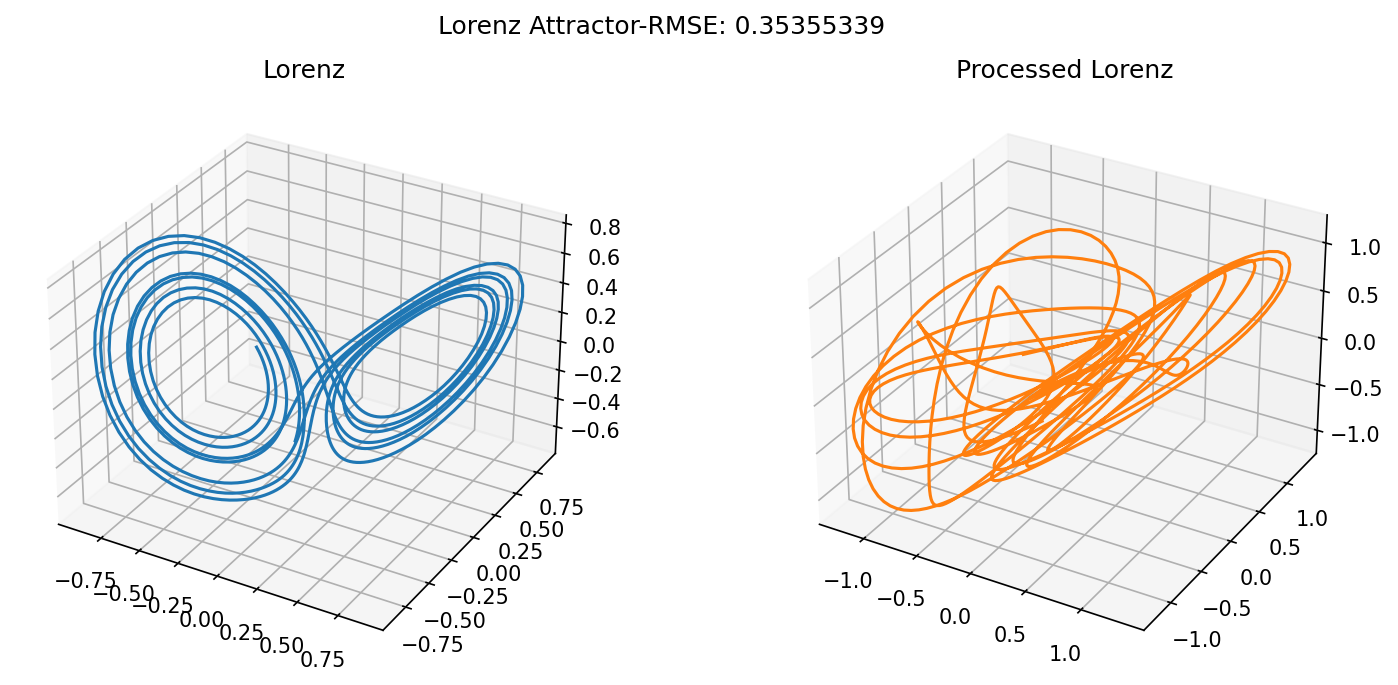

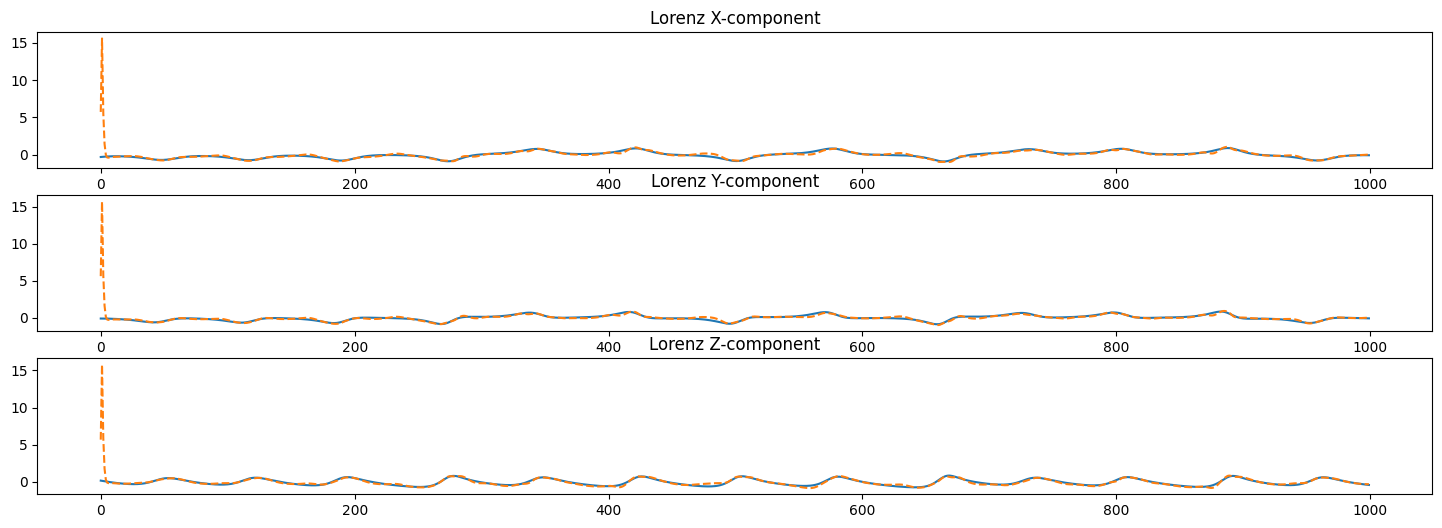

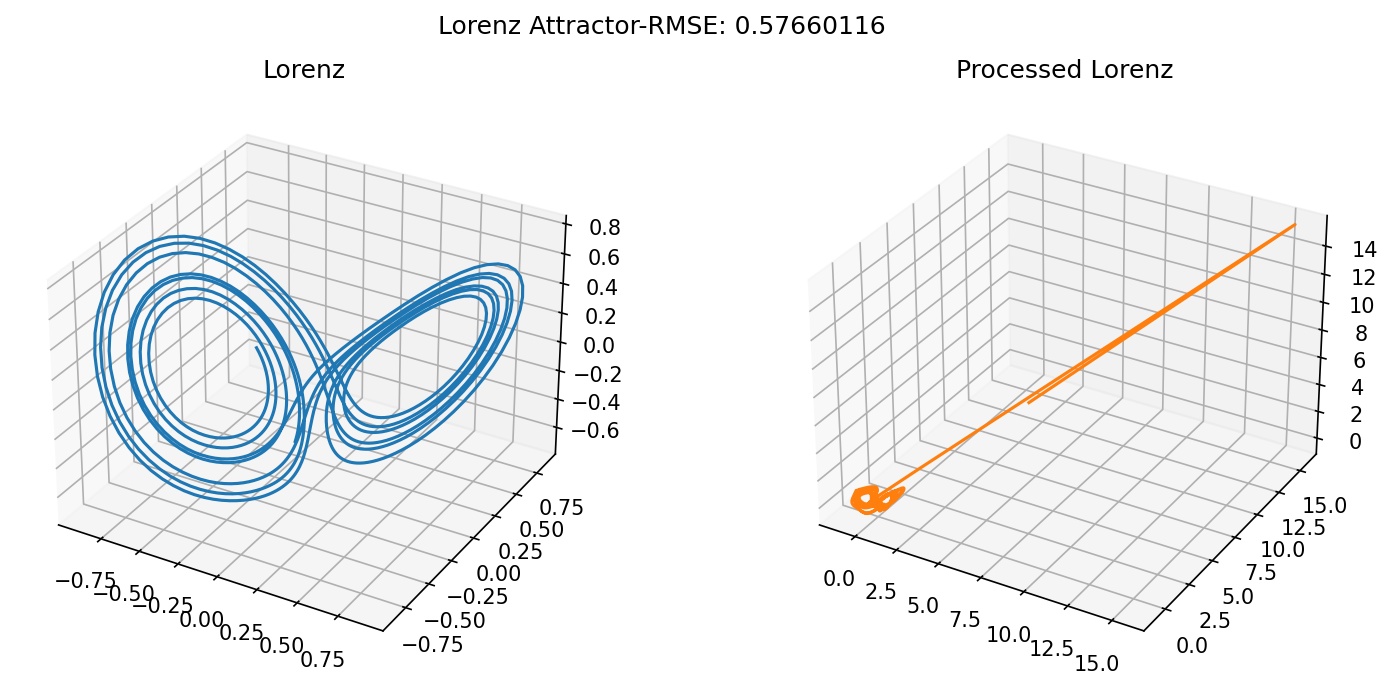

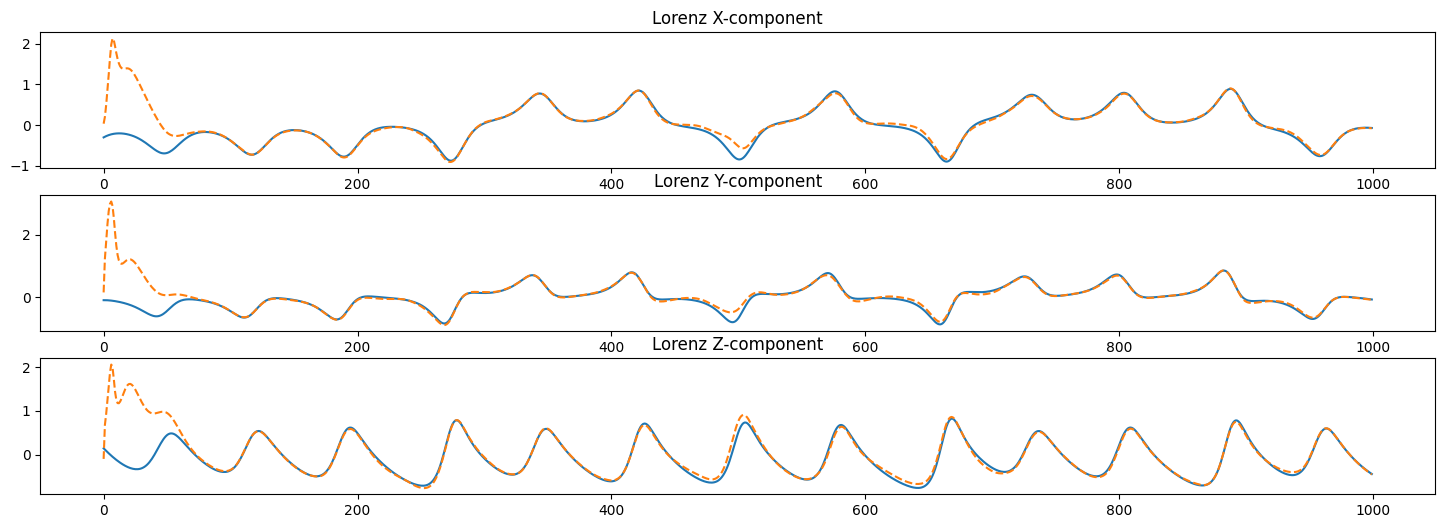

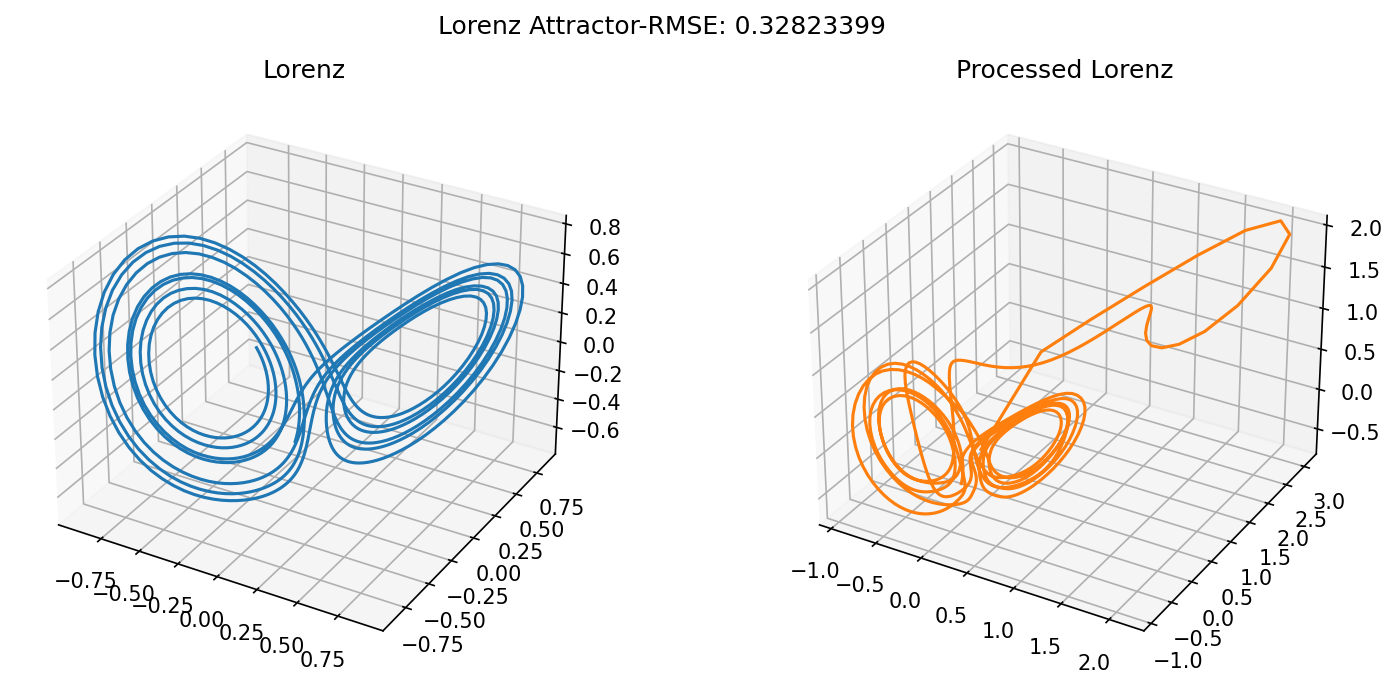

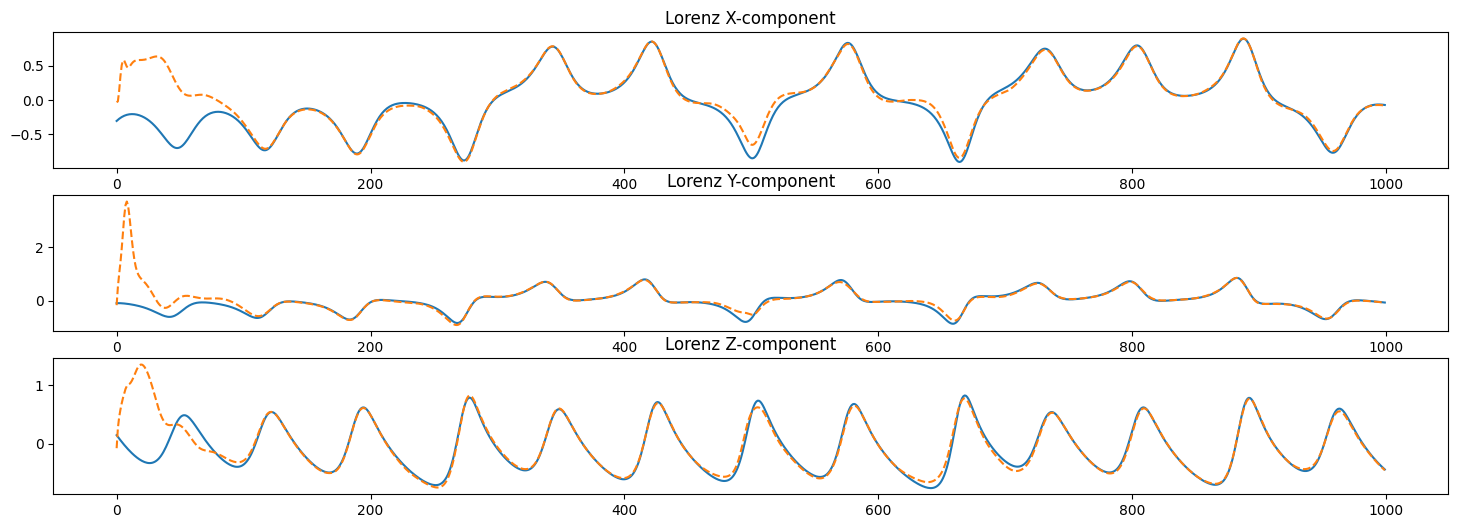

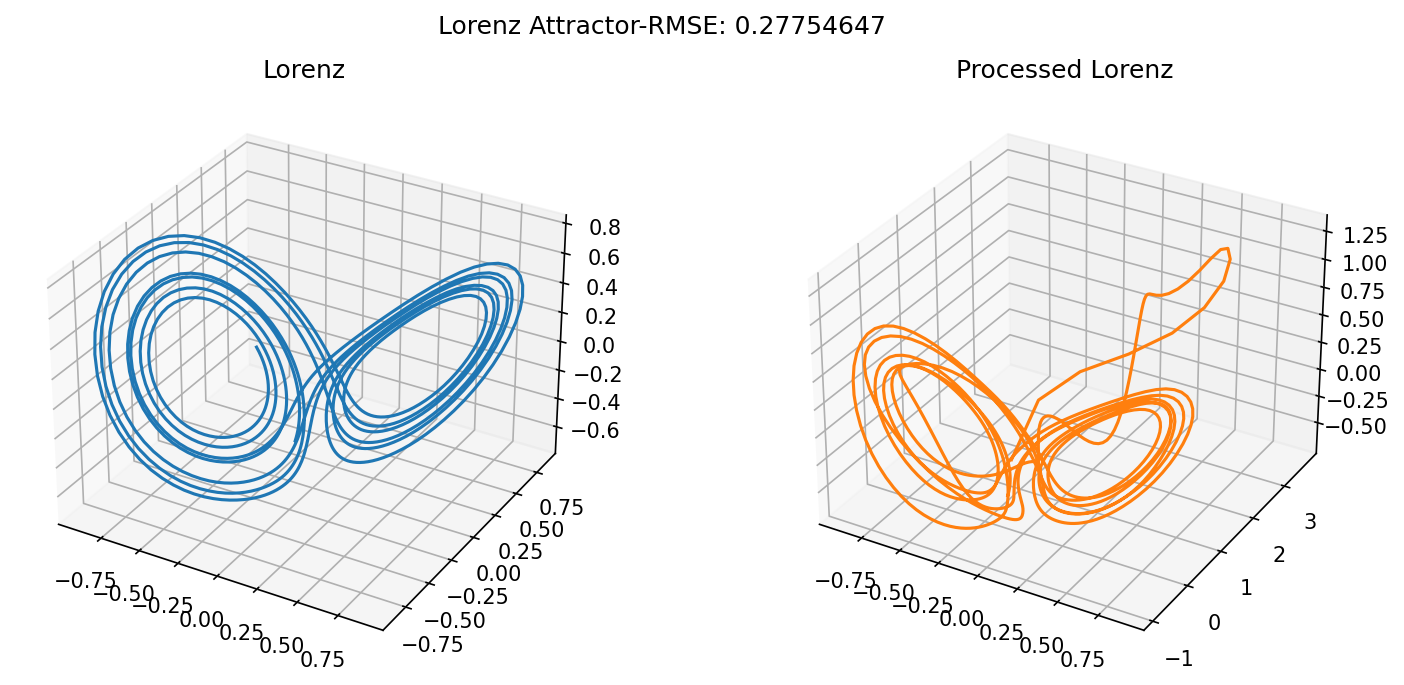

In [13]:
test_data = add_noise(data[1000:2000,:], "sin", noise_level=0.5)
target_test = data[1000:2000,:]

pred = esn.run(test_data, reset=True)

show(test_data, target_test)
show(pred['output1'+str(name_idx)], target_test)
show(pred['output2'+str(name_idx)], target_test)
show(pred['output3'+str(name_idx)], target_test)

In [14]:
input_data = add_noise(data[:1000,:], 'sin', noise_level=0.1)
target_input = data[1:1001,:]

test_data = add_noise(data[1000:2000,:], "sin", noise_level=0.1)
target_test = data[1001:2001,:]

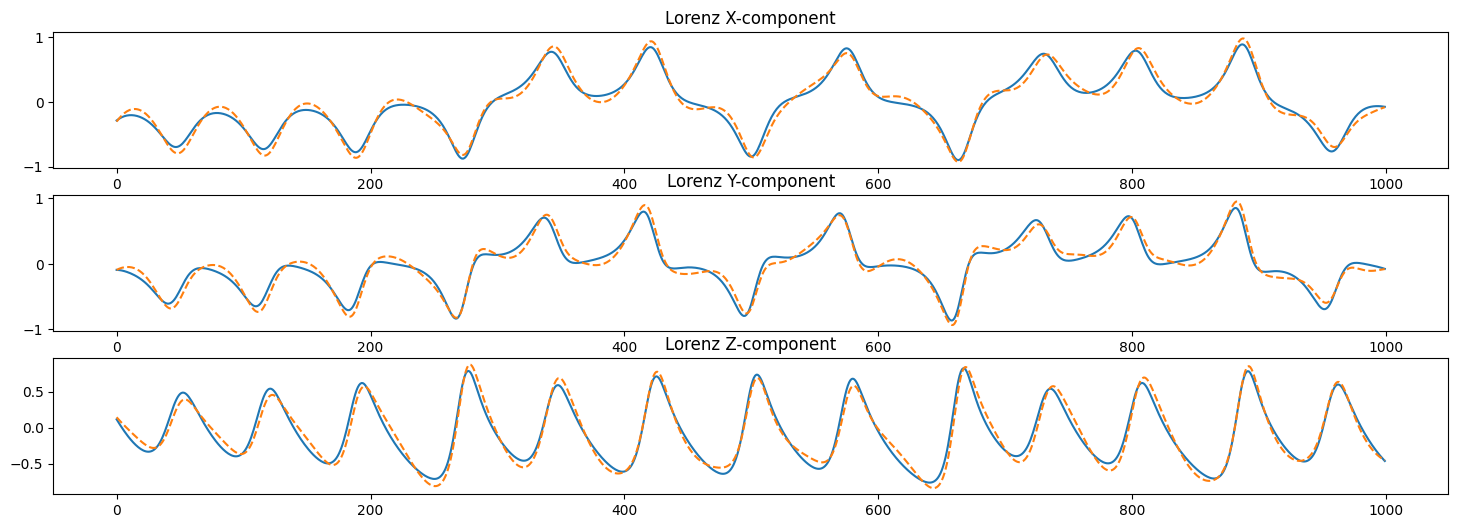

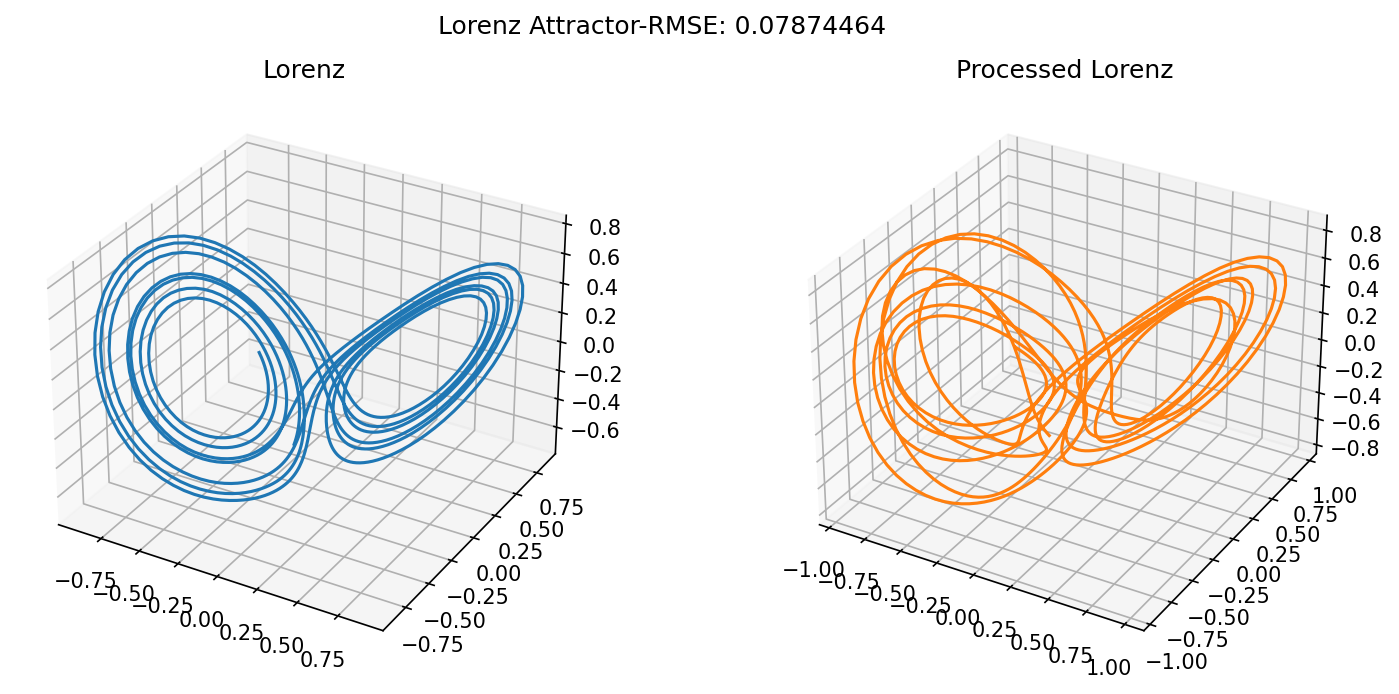

In [15]:
show(test_data, target_test)

In [16]:
inp_1 = rpy.nodes.Input(input_dim=3)
res_1 = rpy.nodes.Reservoir(500, lr=0.3, sr=0.9, equation='internal')
rdo_1 = rpy.nodes.Ridge(output_dim=3, ridge=1e-7)

esn_1 = inp_1 >> res_1 >> rdo_1

In [17]:
esn_1 = esn_1.fit(input_data, target_input, warmup=200)

In [18]:
test_len = 1000
u = input_data[-1,:]

pred = np.zeros((test_len,3))

for t in range(test_len):
    u = esn_1.run(u)
    
    pred[t,:] = u

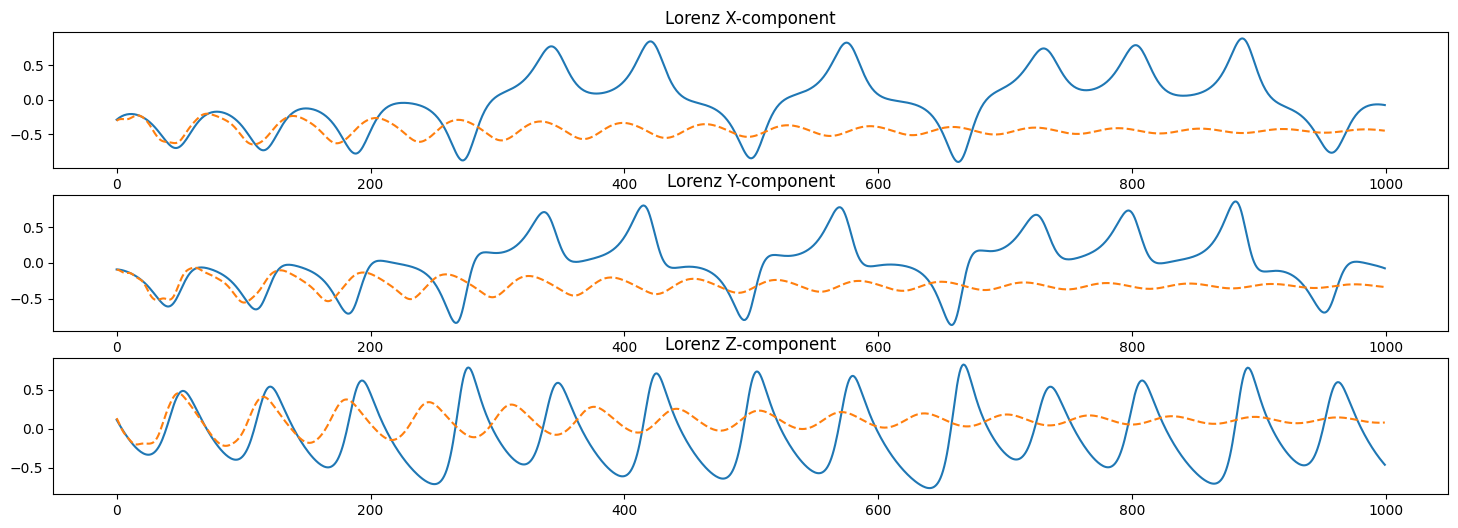

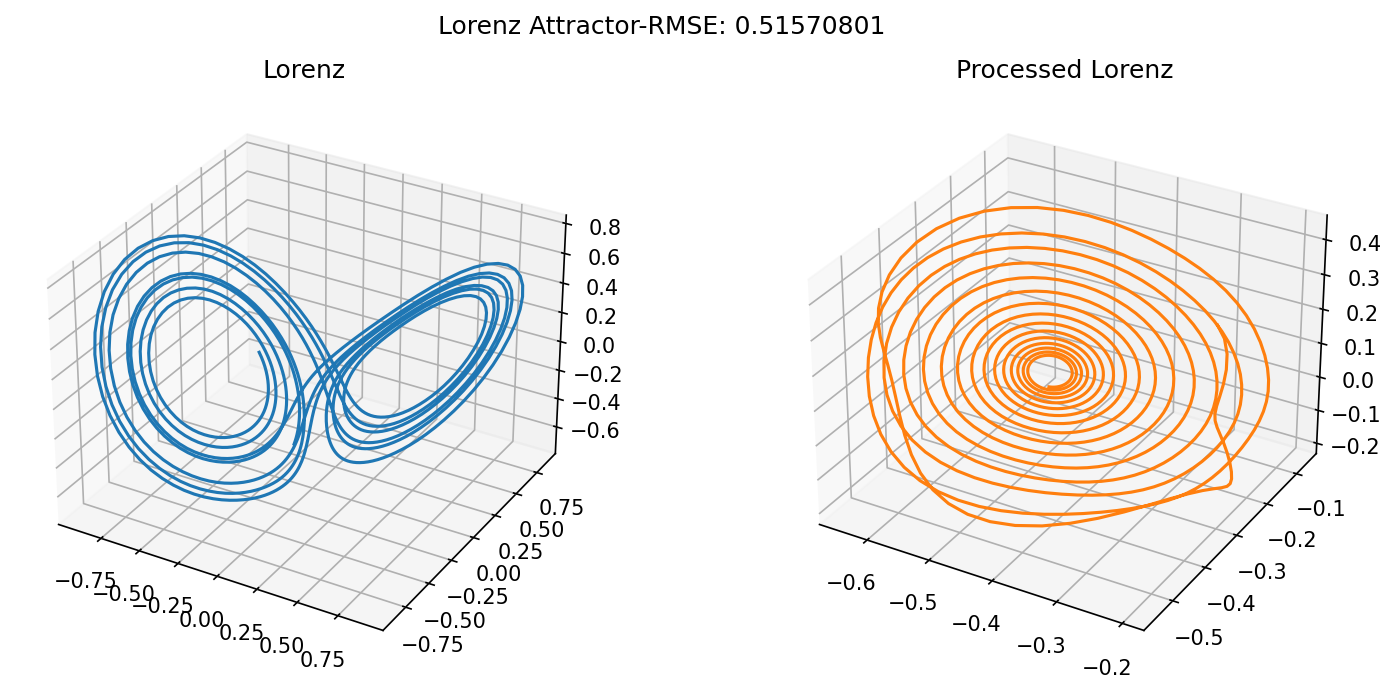

In [19]:
show(pred, target_test)

In [20]:
inp_2 = rpy.nodes.Input(input_dim=3)
res_2 = rpy.nodes.Reservoir(500, lr=0.3, sr=0.9, equation='external')
rdo_2 = rpy.nodes.Ridge(output_dim=3, ridge=1e-7)

esn_2 = inp_2 >> res_2 >> rdo_2
